In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

plt.style.use('science')


In [2]:
filepath="/uscms_data/d3/ekoenig/8BAnalysis/analysis/CMSSW_10_6_28/src/sixB/analysis/sixBanalysis/NMSSM_XYY_YToHH_8b_MX_1000_MY_450.root"

signal = Tree(filepath)

In [3]:
treeiter = ObjIter([signal])

In [4]:
import awkward0 as ak0

gnn_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/graph_dijet/output"

def load_model_output(path):
    output = ak0.load(path)
    scores = ak.from_awkward0(output['scores'][:,:,1])
    min_score, max_score = ak.min(scores, axis=-1), ak.max(scores, axis=-1)
    return (scores - min_score)/(max_score - min_score)

def load_regex_output(regex):
    path = glob.glob(regex)[0]
    return load_model_output(path)

In [5]:
import glob 

gnn_score = load_model_output(f"{gnn_path}/NMSSM_XYY_YToHH_8b_MX_1000_MY_450.awkd")
signal.extend(dijet_gnn_score=gnn_score)


In [6]:
varinfo.dijet_score = dict(bins=np.linspace(0,1,30), xlabel='DiJet Score')
varinfo.dijet_dr    = dict(bins=np.linspace(0,6,30), xlabel='DiJet Jet dR')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


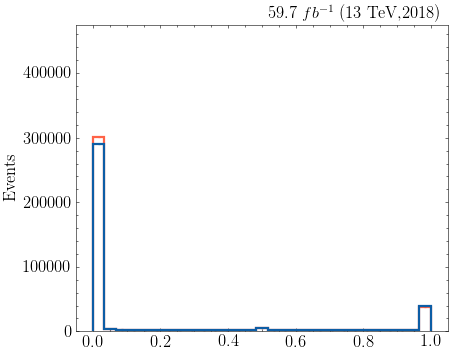

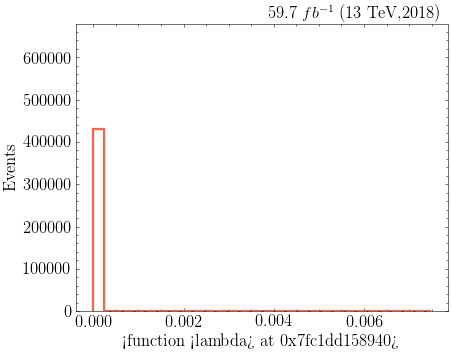

In [7]:
study.overlay(
    treeiter,
    varlist=['dijet_score','dijet_gnn_score'],
)

study.quick(
    treeiter,
    varlist=[lambda t:t.dijet_gnn_score-t.dijet_score]
)

In [8]:
c_score = signal.dijet_score
p_score = signal.dijet_gnn_score

In [21]:
accuracy = np.log(np.abs(p_score-c_score))

(<Figure size 468x468 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

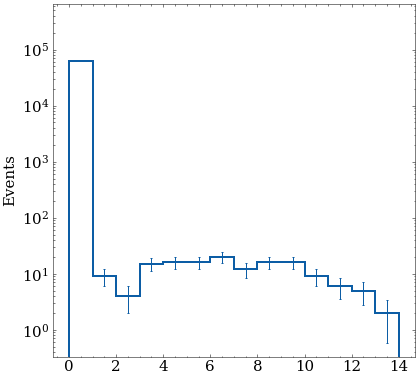

In [48]:
n_bad = ak.sum(accuracy>-4,axis=-1)
hist_multi([n_bad], log=True)

In [49]:
ak.mean(n_bad>0)*100

0.2320997074907796

In [27]:
ak.argmax(n_bad)

14687

In [16]:
ak.argmax(accuracy)

14991

In [76]:
event = signal[0]
event[["Run","LumiSec","Event"]]

<Record {Run: 1, LumiSec: 2, Event: 2} type='{"Run": uint32, "LumiSec": uint32, ...'>

In [82]:
event.higgs_score.to_list(), event.cpp_higgs_score.to_list()

([1.0, 0.9999570846557617, 0.5630844831466675, 1.0],
 [1.0, 1.0, 9.353425411973149e-06, 0.9778082370758057])

In [95]:
order = ak.argsort(-event.dijet_score)

event.dijet_score[order], event.dijet_j1Idx[order], event.dijet_j2Idx[order], event.dijet_signalId[order]

(<Array [1, 1, 1, ... 7.63e-08, 3.39e-08] type='45 * float32'>,
 <Array [0, 1, 1, 7, 0, 2, ... 4, 2, 5, 0, 6, 3] type='45 * int32'>,
 <Array [8, 2, 6, 8, 5, 4, ... 5, 9, 9, 9, 8, 9] type='45 * int32'>,
 <Array [-1, -1, 1, -1, 0, ... -1, -1, -1, -1] type='45 * int32'>)

In [94]:
event.cpp_higgs_score, event.cpp_higgs_j1Idx, event.cpp_higgs_j2Idx, event.cpp_higgs_signalId

(<Array [1, 1, 9.35e-06, 0.978] type='4 * float32'>,
 <Array [1, 0, 3, 6] type='4 * int32'>,
 <Array [2, 8, 4, 7] type='4 * int32'>,
 <Array [-1, -1, -1, -1] type='4 * int32'>)

In [90]:
event.dijet_score[order].to_list()

[1.0,
 1.0,
 1.0,
 0.9999945163726807,
 0.999969482421875,
 0.9999570846557617,
 0.9999479055404663,
 0.9876136779785156,
 0.9778082370758057,
 0.8913600444793701,
 0.8559563159942627,
 0.5630844831466675,
 0.5,
 0.3316943347454071,
 0.13140927255153656,
 0.0002147224295185879,
 9.353425411973149e-06,
 8.631129276182037e-06,
 6.641438176302472e-06,
 4.860582976107253e-06,
 3.673659875857993e-06,
 3.507999963403563e-06,
 2.909744807766401e-06,
 2.74323019766598e-06,
 1.9976232579210773e-06,
 1.7895998780659284e-06,
 1.765551701282675e-06,
 1.6943124592216918e-06,
 1.5075291912580724e-06,
 1.1263023225183133e-06,
 1.0302112514182227e-06,
 1.020541049001622e-06,
 6.255460220927489e-07,
 6.11354323609703e-07,
 5.119820798427099e-07,
 4.525181225289998e-07,
 2.561919529853185e-07,
 2.386321114045131e-07,
 2.2528557508394442e-07,
 2.1121459781170415e-07,
 1.4723742935984774e-07,
 1.2546855998607498e-07,
 8.833374209871181e-08,
 7.632787912825734e-08,
 3.3873913451998305e-08]

In [10]:
build_collection(signal, 'H\dY\d', 'higgs', ptordered=True)

In [53]:
select_higgs(signal, field='gnn_score', tag='gnn', nhiggs=4)
select_higgs(signal, field='score', tag='cpp', nhiggs=4)


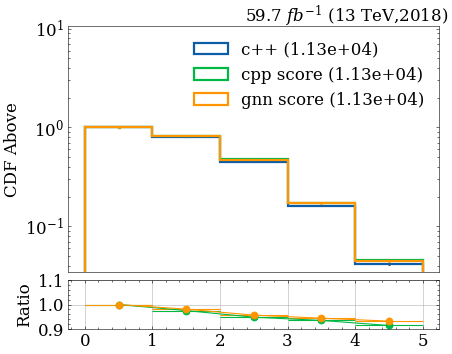

In [75]:
study.overlay(
  [signal],h_color=None,label=['c++','cpp score','gnn score'], legend=True,
  varlist=['nfound_paired_h',lambda t:ak.sum(t.cpp_higgs_signalId>-1,axis=-1),lambda t:ak.sum(t.gnn_higgs_signalId>-1,axis=-1)],
  cumulative=-1,log=True,
  ratio=True, r_ylim=(0.9,1.1)
)

(<Figure size 468x468 with 1 Axes>, <AxesSubplot:ylabel='CDF Above'>)

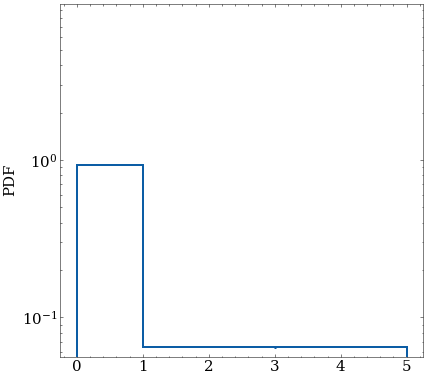

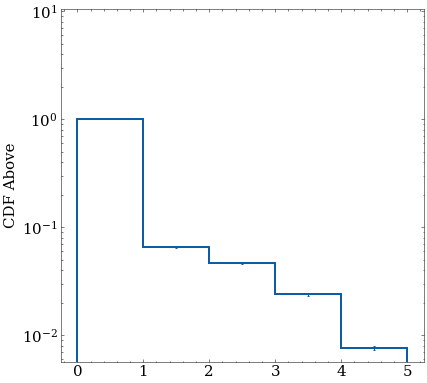

In [70]:
j1Idx_diff = signal.cpp_higgs_j1Idx - signal.gnn_higgs_j1Idx
j1Idx_diff = ak.where(j1Idx_diff == 0, 0, 1)
j2Idx_diff = signal.cpp_higgs_j2Idx - signal.gnn_higgs_j2Idx
j2Idx_diff = ak.where(j2Idx_diff == 0, 0, 1)
dijet_diff = j1Idx_diff & j2Idx_diff
n_dijets_bad = ak.sum(dijet_diff, axis=-1)

hist_multi([n_dijets_bad], density=True, log=True, bins=np.array([0,1,5]))
hist_multi([n_dijets_bad], cumulative=-1, log=True)
